In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import datetime
import warnings
import itertools
from IPython.core.display import HTML
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import pickle
warnings.filterwarnings("ignore")

hmm.GMMHMM(n_components=1, n_mix=1, min_covar=0.001, startprob_prior=1.0, transmat_prior=1.0, weights_prior=1.0, means_prior=0.0, means_weight=0.0, covars_prior=None, covars_weight=None, algorithm='viterbi', covariance_type='diag', random_state=None, n_iter=10, tol=0.01, verbose=False, params='stmcw', init_params='stmcw')

In [2]:
company = 'MSFT'hmm = GaussianHMM(n_components=4, covariance_type='diag', n_iter=100000, tol=1e-8)

In [3]:
def load_dataset(test_size=0.2):
    data = pd.read_csv('./data/MSFT.csv')
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    test_data = test_data[::-1]
    print('Size of Dataset: {ds_size} -- Train Set: {tr_size} -- Test Set: {ts_size}'.
    format(ds_size=len(data), tr_size=len(train_data), ts_size=len(test_data)))

    display(HTML((data.describe()).to_html()))
    display(HTML((data.head(5)).to_html()))

    end_date = datetime.date.today()

    sample_data = data.head(100)
    plt.figure(figsize=(12, 5), dpi=80) 
    plt.title("MSFT" + " - 100 Samples", fontsize = 14)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.gca().xaxis.set_minor_locator(MonthLocator())
    plt.plot_date(sample_data['Date'],sample_data['Open'],'-')
    plt.plot_date(sample_data['Date'],sample_data['Close/Last'],'-')
    plt.plot_date(sample_data['Date'],sample_data['High'],'-')
    plt.plot_date(sample_data['Date'],sample_data['Low'],'-')
    plt.legend(['Opening', 'Closing', 'Highest', 'Lowest'])
    plt.show()

    plt.figure(figsize=(12, 5), dpi=80)
    plt.title("MSFT" + " - Closing Price", fontsize = 14)
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.plot_date(data['Date'],data['Close/Last'],'-')
    plt.show()

    corr = data.corr(method='pearson', min_periods=1)
    sns.heatmap(corr, annot=True,)
    
    return train_data,test_data   
    return train_data,test_data

Size of Dataset: 2515 -- Train Set: 2012 -- Test Set: 503


,Date,Close/Last,Volume,Open,High,Low,Prev_Close
count,2515.000000,2515.000000,2.515000e+03,2515.000000,2515.000000,2515.000000,2515.000000
mean,737380.516899,183.011024,2.889874e+07,182.975506,184.714184,181.139569,182.860952
std,1053.884929,120.735563,1.332359e+07,120.749893,121.796187,119.571635,120.666856
min,735555.000000,40.290000,7.425603e+06,40.340000,40.740000,39.720000,40.290000
25%,736467.500000,68.935000,2.065305e+07,68.880000,69.330000,68.400000,68.870000
50%,737378.000000,144.610000,2.583302e+07,144.900000,147.462500,143.510000,144.550000
75%,738291.500000,278.430000,3.317227e+07,278.582500,281.560000,275.830000,277.975000
max,739204.000000,467.560000,1.691150e+08,467.000000,468.350000,464.460000,467.560000


,Date,Close/Last,Volume,Open,High,Low,Prev_Close
0,735555,48.74,23938060,49.13,49.3250,48.70,49.46
1,735556,48.22,26166200,48.66,48.7549,47.93,48.74
2,735557,48.70,21486310,48.00,48.7000,47.87,48.22
3,735558,47.98,42867970,49.02,49.0500,47.57,48.70
4,735561,47.59,34266860,47.99,48.0000,47.39,47.98


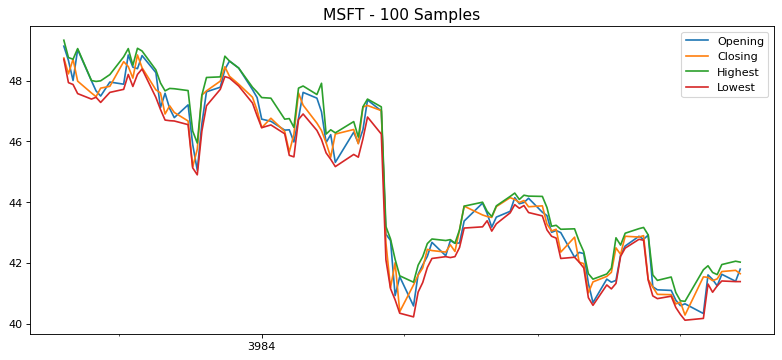

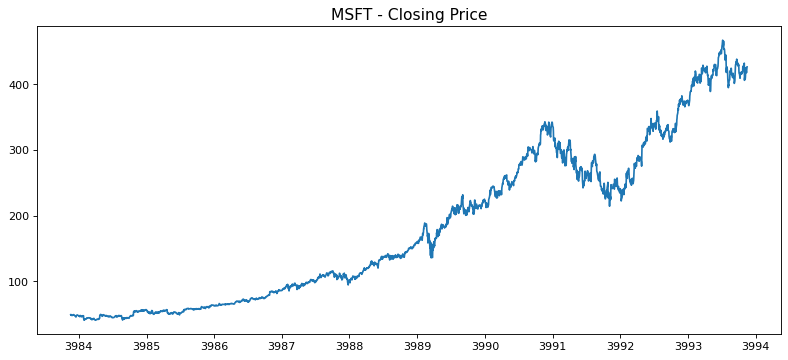

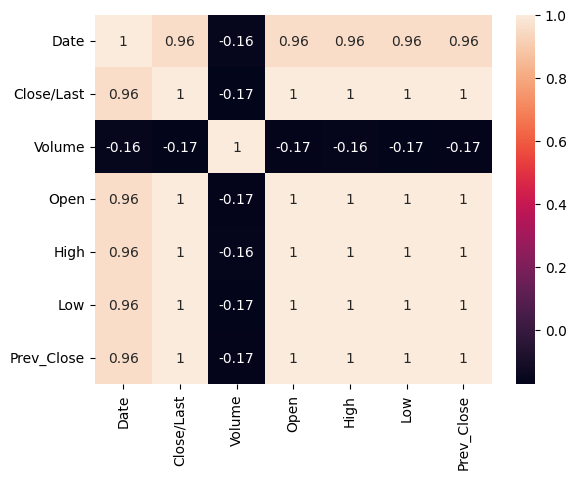

In [4]:
train_data, test_data = load_dataset()

In [5]:
def extract_features(data):
    open_price = np.array(data['Open'])
    close_price = np.array(data['Close/Last'])
    high_price = np.array(data['High'])
    low_price = np.array(data['Low'])

    frac_change = (close_price - open_price) / open_price
    frac_high = (high_price - open_price) / open_price
    frac_low = (open_price - low_price) / open_price

    return np.column_stack((frac_change, frac_high, frac_low))

In [6]:
def clean_dataset(data):
    df = pd.DataFrame(data)
    df.dropna(inplace=True)
    # indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [7]:
def fit(model, dataset):
    feature_vector = extract_features(dataset)
    print('Samples Before Cleaning:', len(feature_vector))
    data = clean_dataset(feature_vector)
    print('Samples After Cleaning:', len(data))

    feature_vector = data
    data.columns= ['FracChange', 'FracHigh','FracLow']
    display(HTML((data.head(5)).to_html()))

    feature_vector = data.to_numpy()
    model.fit(feature_vector)

In [9]:
fit(hmm,train_data)


Samples Before Cleaning: 2012
Samples After Cleaning: 2012


,FracChange,FracHigh,FracLow
0,-0.007938,0.003969,0.008752
1,-0.009042,0.001950,0.015002
2,0.014583,0.014583,0.002708
3,-0.021216,0.000612,0.029580
4,-0.008335,0.000208,0.012503


In [10]:
def compute_possible_outcomes(n_steps_frac_change=50, n_steps_frac_high=10, n_steps_frac_low=10):
    frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
    frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
    frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
    
    possible_outcomes = np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
    return possible_outcomes

In [11]:
def get_most_probable_outcome(model, test_data, day_index, n_latency_days=30):
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_end_index: previous_data_start_index]
    previous_data_features = extract_features(previous_data)
    previous_data_features = (clean_dataset (previous_data_features)).to_numpy()
    outcome_score = []
    possible_outcomes = compute_possible_outcomes()
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((previous_data_features, possible_outcome))
        outcome_score.append(model.score(total_data))
    
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]
    return most_probable_outcome

In [12]:
def predict_close_price(model, test_data, day_index):
    open_price = test_data.iloc[day_index]['Open']
    predicted_frac_change, _, _ = get_most_probable_outcome(model, test_data, day_index)
    return open_price * (1 + predicted_frac_change)

In [13]:
def predict_close_prices_series(model, test_data, days):
    predicted_close_prices = []
    for day_index in tqdm(range(days)):
        predicted_close_prices.append(predict_close_price(model, test_data, day_index))

    test_data = test_data[0: days]
    days = np.array(test_data['Date'], dtype="datetime64[ms]")
    actual_close_prices = test_data['Close/Last']

    data = list(zip(days, actual_close_prices, predicted_close_prices))
    data =  pd.DataFrame(data, columns=['Date','Actual Price', 'Predicted Price'])
    data.reset_index(drop=True, inplace=True)
    data =  data.iloc[::-1]
    data.reset_index(drop=True, inplace=True)
    display(HTML(data.to_html()))

    plt.figure(figsize=(12, 5), dpi=80) 
    plt.title(company, fontsize = 14)
    plt.plot_date(days,actual_close_prices, 'o-')
    plt.plot_date(days,predicted_close_prices,'rx-')
    plt.legend(['Actual Price','Predicted Price'])
    plt.show()


    return data

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.13s/it]


,Date,Actual Price,Predicted Price
0,1970-01-01 00:12:19.177,418.16,416.288694
1,1970-01-01 00:12:19.180,418.78,415.270776
2,1970-01-01 00:12:19.181,427.51,417.635939
3,1970-01-01 00:12:19.182,424.60,429.975704
4,1970-01-01 00:12:19.183,424.73,424.456990
5,1970-01-01 00:12:19.184,428.15,425.889061
6,1970-01-01 00:12:19.187,426.59,430.774071
7,1970-01-01 00:12:19.188,431.95,427.126531
8,1970-01-01 00:12:19.189,432.53,436.542276
9,1970-01-01 00:12:19.190,406.35,414.512327


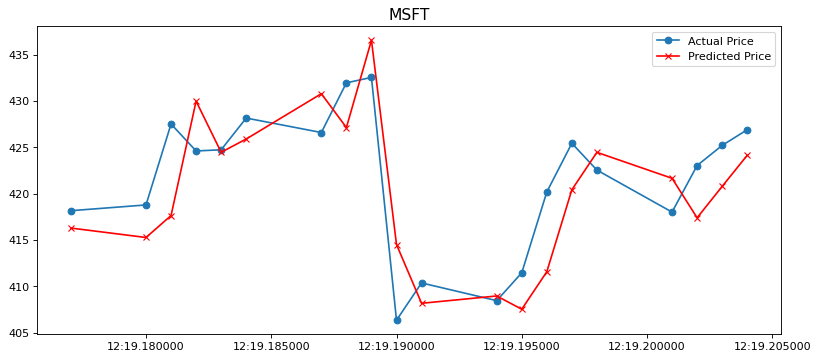

In [14]:
output = predict_close_prices_series(hmm, test_data, 20)

In [19]:
def eval_metrics(output):
    abs_diff = np.abs(output['Actual Price'] - output['Predicted Price'])

    MAE = np.mean(abs_diff)
    MSE = np.mean(abs_diff ** 2)
    RMSE = np.sqrt(MSE)
    RMSLE = np.log(RMSE)
    print("RMSLE: ", RMSLE)
    MAPE = np.mean((abs_diff*100/output['Actual Price']))

    metrices = [MAE, RMSE, MAPE]

    pd.set_option("display.precision", 4)
    metrices = pd.DataFrame(metrices, index =['MAE', 'RMSE', 'MAPE'], columns =['Score'])
    display(HTML(metrices.to_html()))

In [20]:
eval_metrics(output)

RMSLE:  1.5744930986226349


,Score
MAE,4.1473
RMSE,4.8283
MAPE,0.9832
